In [ ]:
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('karanravindra/mnist-autoencoder/model-s8lnnp8k:v0', type='model')
# artifact_dir = artifact.download()
# run.finish()

In [1]:
import warnings
from collections import Counter

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchinfo import summary
from torchmetrics.functional.image.ssim import structural_similarity_index_measure as ssim_func
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
from nn_zoo.datamodules import MNISTDataModule
from nn_zoo.models.components import DepthwiseSeparableConv2d, VectorQuantizer, SelfAttention

import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from einops import rearrange
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

/Users/karan/projects/playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import nn
from torch.nn import functional as F
from torchinfo import summary
from nn_zoo.models.components import DepthwiseSeparableConv2d, VectorQuantizer
from torchmetrics.functional.image.ssim import (
    structural_similarity_index_measure as ssim_func,
)
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS

import warnings

warnings.filterwarnings("ignore")


class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(Block, self).__init__()
        self.layers = nn.ModuleList(
            [
                self._block(in_channels, out_channels)
                if i == 0
                else self._block(out_channels, out_channels)
                for i in range(num_layers)
            ]
        )

    def _block(self, in_channels: int, out_channels: int):
        return nn.Sequential(
            nn.GroupNorm(in_channels // 4 if in_channels >= 4 else 1, in_channels),
            nn.GELU(),
            DepthwiseSeparableConv2d(in_channels, out_channels, 3),
        )

    def forward(self, x):
        x = self.layers[0](x)
        for i, layer in enumerate(self.layers[1:]):
            x = layer(x) + x
        return x


class DownBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, depth: int):
        super(DownBlock, self).__init__(
            Block(in_channels * 4, out_channels, depth),
            # nn.MaxPool2d(2)
            nn.PixelUnshuffle(2),
        )


class UpBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, depth: int):
        super(UpBlock, self).__init__()
        self.block = nn.Sequential(
            nn.PixelShuffle(2),
            # nn.Upsample(scale_factor=2, mode="nearest"),
            Block(in_channels, out_channels * 4, depth),
        )

    def forward(self, x):
        return self.block(x)


class AutoEncoder(nn.Module):
    def __init__(self, width: int, depth: int):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            Block(1, width * 4, depth),
            DownBlock(width, width, depth),
            DownBlock(width, width, depth),
            DownBlock(width, width, depth),
        )
        self.proj_in = nn.Identity()
        self.vq = nn.Identity()
        self.proj_out = nn.Identity()
        self.decoder = nn.Sequential(
            UpBlock(width, width, depth),
            UpBlock(width, width, depth),
            UpBlock(width, width, depth),
            Block(width * 4, 1, depth),
            nn.Sigmoid(),
        )
        self.apply(self._init_weights)

        # self.register_module("lpips", LPIPS(net_type="squeeze", normalize=True))

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.encoder(x)
        x = self.proj_in(x)
        if isinstance(self.vq, nn.Identity):
            x = self.vq(x)
        else:
            x, *_ = self.vq(x)
        x = self.proj_out(x)
        x = self.decoder(x)

        return x

    # @staticmethod
    def loss(self, x, y):
        mse = F.mse_loss(x, y)
        bce = F.binary_cross_entropy(x, y)
        psnr = 10 * (1 / mse).log10()
        ssim = ssim_func(x, y)
        # lpips = self.lpips(x.repeat(1, 3, 1, 1), y.repeat(1, 3, 1, 1))

        return {
            "loss": bce, # + lpips,
            "bce": bce,
            "mse": mse,
            "ssim": ssim,
            "psnr": psnr,
            # "lpips": lpips,
        }

In [3]:
model = AutoEncoder(width=4, depth=2)
state_dict=torch.load('../../mnist-autoencoder/jg8jxsd2/checkpoints/epoch=29-step=28140.ckpt', map_location=torch.device('cpu'))['state_dict']
err = model.load_state_dict(dict(map(lambda x: (x[0].replace("model.", ""), x[1]), state_dict.items())), strict=False)
# model.lpips = None
model = model.to("mps")
print(err)

for param in model.parameters():
    param.requires_grad = False

_IncompatibleKeys(missing_keys=[], unexpected_keys=['lpips.net.net.slices.0.0.weight', 'lpips.net.net.slices.0.0.bias', 'lpips.net.net.slices.1.3.squeeze.weight', 'lpips.net.net.slices.1.3.squeeze.bias', 'lpips.net.net.slices.1.3.expand1x1.weight', 'lpips.net.net.slices.1.3.expand1x1.bias', 'lpips.net.net.slices.1.3.expand3x3.weight', 'lpips.net.net.slices.1.3.expand3x3.bias', 'lpips.net.net.slices.1.4.squeeze.weight', 'lpips.net.net.slices.1.4.squeeze.bias', 'lpips.net.net.slices.1.4.expand1x1.weight', 'lpips.net.net.slices.1.4.expand1x1.bias', 'lpips.net.net.slices.1.4.expand3x3.weight', 'lpips.net.net.slices.1.4.expand3x3.bias', 'lpips.net.net.slices.2.6.squeeze.weight', 'lpips.net.net.slices.2.6.squeeze.bias', 'lpips.net.net.slices.2.6.expand1x1.weight', 'lpips.net.net.slices.2.6.expand1x1.bias', 'lpips.net.net.slices.2.6.expand3x3.weight', 'lpips.net.net.slices.2.6.expand3x3.bias', 'lpips.net.net.slices.2.7.squeeze.weight', 'lpips.net.net.slices.2.7.squeeze.bias', 'lpips.net.net.s

In [4]:
dm = MNISTDataModule(
        data_dir="../../data",
        dataset_params={
            "download": True,
            "transform": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((32, 32)),
                    torchvision.transforms.ToTensor(),
                ]
            ),
        },
        loader_params={
            "batch_size": 128,
        },
    )

dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [5]:
latents = []

with torch.no_grad():
    model.eval()
    for batch in train_loader:
        x, y = batch
        x = x.to("mps")

        x = model.encoder(x)
        x = model.proj_in(x)
        if isinstance(model.vq, nn.Identity):
            x = model.vq(x)
        else:
            x, *_ = model.vq(x)
        latents.append(x)

    latents = torch.cat(latents, dim=0).cpu()

In [6]:
pca = PCA(n_components=3, n_oversamples=10)
pca.fit(latents.permute(0, 2, 3, 1).reshape(-1, latents.shape[1]))

latents_pca = pca.transform(latents.permute(0, 2, 3, 1).reshape(-1, latents.shape[1]))

# clusters
clusters = KMeans(n_clusters=256)
clusters.fit(latents.permute(0, 2, 3, 1).reshape(-1, latents.shape[1]))

clustered = clusters.predict(latents.permute(0, 2, 3, 1).reshape(-1, latents.shape[1]))

print(latents_pca.shape, clusters.cluster_centers_.shape, latents.permute(0, 2, 3, 1).reshape(-1, latents.shape[1]).shape)

# fig = px.scatter_3d(
#         x=latents_pca[:, 0],
#         y=latents_pca[:, 1],
#         z=latents_pca[:, 2],
#         title="PCA of latents",
#         height=800,
#         width=800,
#         opacity=0.1,
#         color=clustered,
#         # color=val_loader.dataset.targets.unsqueeze(1).repeat(1, 16).flatten(),
#         labels={"color": "Digit"},
#     )
# fig.show()

(960000, 3) (256, 16) torch.Size([960000, 16])


In [7]:
model.vq = VectorQuantizer(16, 256, use_ema=False, decay=0.99, epsilon=1e-8).to("mps")
assert tuple(model.vq.e_i_ts.shape) == clusters.cluster_centers_.shape[::-1], (model.vq.e_i_ts.shape, clusters.cluster_centers_.shape) + "e_i_ts shape is not correct"
model.vq.e_i_ts = nn.Parameter(torch.as_tensor(clusters.cluster_centers_.astype("float32"), device="mps").permute(1, 0))

for param in model.parameters():
    param.requires_grad = False

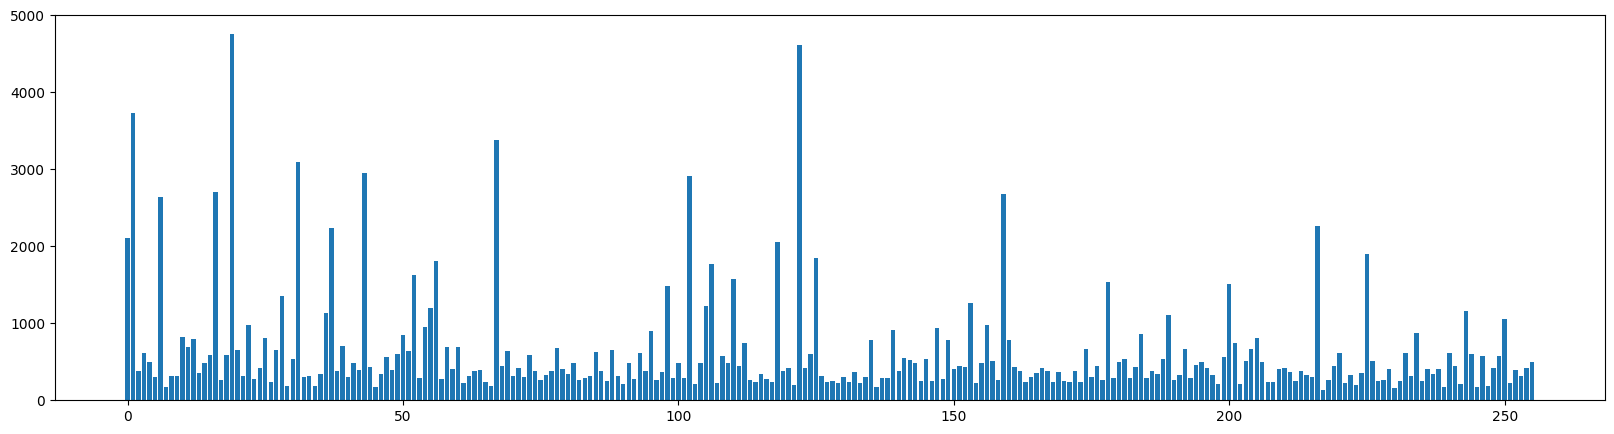

In [8]:
with torch.no_grad():
    counter = Counter()
    model.eval()
    for batch in val_loader:
        x, y = batch
        x = x.to("mps")

        x = model.encoder(x)
        x = model.proj_in(x)
        _, _, _, indices = model.vq(x)

        counter.update(indices.flatten().tolist())

plt.figure(figsize=(20, 5))
plt.bar(counter.keys(), counter.values())
plt.show()

In [11]:
from einops.layers.torch import Rearrange, Reduce

# model.proj_in = DepthwiseSeparableConv2d(16, 16, 1, padding=0).to("mps")
# model.proj_out = DepthwiseSeparableConv2d(16, 16, 1, padding=0).to("mps")

model.proj_in = nn.Sequential( # BCHW -> B(HW)C
    Rearrange("b c h w -> b (h w) c"),
    nn.Linear(16, 16),
    Rearrange("b (h w) c -> b c h w", h=4, w=4)
)
model.proj_out = nn.Sequential(
    Rearrange("b c h w -> b (h w) c"),
    nn.Linear(16, 16),
    Rearrange("b (h w) c -> b c h w", h=4, w=4)
)

print(summary(model, input_size=(1, 1, 32, 32), device="mps", depth=1, col_names=["output_size", "num_params", "params_percent"]))
evaluate(model, val_loader, device="mps")

Layer (type:depth-idx)                                                 Output Shape              Param #                   Param %
AutoEncoder                                                            [1, 1, 32, 32]            --                             --
├─Sequential: 1-1                                                      [1, 16, 4, 4]             (1,492)                    18.35%
├─Sequential: 1-2                                                      [1, 16, 4, 4]             272                         3.35%
├─VectorQuantizer: 1-3                                                 [1, 16, 4, 4]             (4,096)                    50.38%
├─Sequential: 1-4                                                      [1, 16, 4, 4]             272                         3.35%
├─Sequential: 1-5                                                      [1, 1, 32, 32]            (1,999)                    24.58%
Total params: 8,131
Trainable params: 544
Non-trainable params: 7,587
Total mult-ad

tensor(0.1345, device='mps:0')

In [10]:
@torch.no_grad()
def evaluate(model, val_loader, device="cpu"):
    model.eval()
    mse = 0
    dict_loss = 0
    for batch in val_loader:
        x, y = batch
        x = x.to(device)

        x_hat = model.encoder(x)
        x_hat = model.proj_in(x_hat)
        x_hat, dict_l, _, _ = model.vq(x_hat)
        x_hat = x_hat
        x_hat = model.proj_out(x_hat)
        x_hat = model.decoder(x_hat)

        mse += F.mse_loss(x_hat, x)
        dict_loss += dict_l

    val_loss = mse + dict_loss
    mse, dict_loss = mse / len(val_loader), dict_loss / len(val_loader)
    print(f"MSE: {mse:.4f}, Dict: {dict_loss:.4f}")
    val_loss /= len(val_loader)
    return val_loss

evaluate(model, val_loader, device="mps")

MSE: 0.1072, Dict: 0.0382


tensor(0.1454, device='mps:0')

In [12]:
from ema_pytorch import EMA
model.train()
optimizer = torch.optim.AdamW([
        # {"params": model.encoder.parameters(), 'lr': 0},
        {"params": model.proj_in.parameters(), 'lr': 8e-4},
        # {"params": model.vq.parameters(), 'lr': 0},
        {"params": model.proj_out.parameters(), 'lr': 8e-4},
        # {"params": model.decoder.parameters(), 'lr': 0},
    ], lr=0)

ema = EMA(model, beta=0.999, update_after_step=100, update_every=10)

In [13]:
# Training loop
for epoch in range(10):
    model.eval()
    val_loss = evaluate(model, val_loader, device="mps")

    model.train()
    pbar = tqdm(train_loader)
    for batch in pbar:
        
        x, y = batch
        x = x.to("mps")

        x_hat = model.encoder(x)
        x_hat = model.proj_in(x_hat)
        x_hat, dict_loss, _, _ = model.vq(x_hat)
        x_hat = x_hat
        x_hat = model.proj_out(x_hat)
        x_hat = model.decoder(x_hat)

        loss = model.loss(x_hat, x)["bce"] + dict_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ema.update()

        pbar.set_postfix_str(f"loss: {loss.item():.4f}, val_loss: {val_loss:.4f}")
        

MSE: 0.1038, Dict: 0.0307


100%|██████████| 469/469 [00:17<00:00, 26.82it/s, loss: 0.9006, val_loss: 0.1345]


MSE: 0.1047, Dict: 0.0887


 17%|█▋        | 81/469 [00:02<00:13, 28.42it/s, loss: 0.4767, val_loss: 0.1933]


KeyboardInterrupt: 

In [14]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.norm().item())

proj_in.1.weight 0.4693949222564697
proj_in.1.bias 0.5462422370910645
proj_out.1.weight 0.3344919979572296
proj_out.1.bias 0.6258772611618042


{   'bce': 0.35172852873802185,
    'loss': 0.35172852873802185,
    'mse': 0.06953414529561996,
    'psnr': 11.578020095825195,
    'ssim': 0.14965033531188965}
tensor(1.7967e-33, device='mps:0', grad_fn=<MinBackward1>) tensor(0.9545, device='mps:0', grad_fn=<MaxBackward1>)


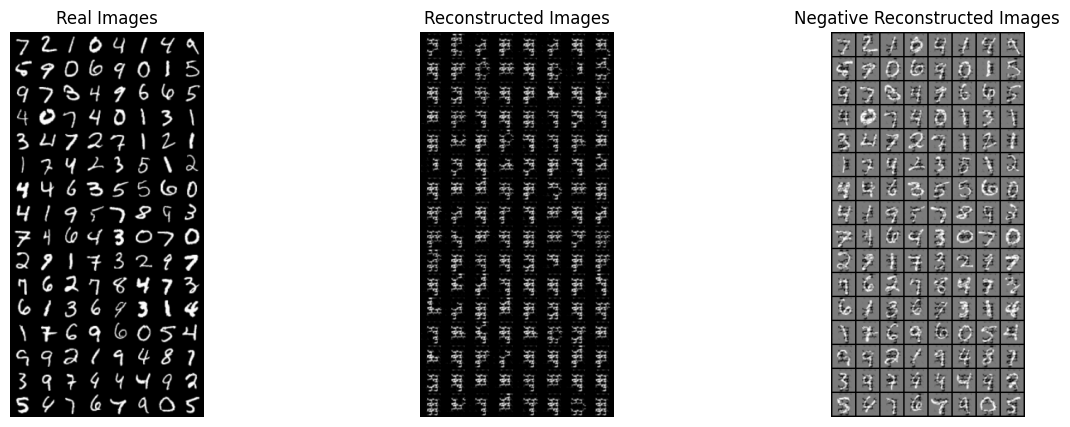

In [15]:
import pprint
import textwrap

# plot reconstruction
x, y = next(iter(val_loader))
x = x.to("mps")

x_hat = model.encoder(x)
# x_hat = rearrange(x_hat, "b c h w -> b (h w) c", h=4, w=4)
x_hat = model.proj_in(x_hat)
# x_hat = rearrange(x_hat, "b (h w) c -> b c h w", h=4, w=4)
x_hat, _, _, _ = model.vq(x_hat)
# x_hat = rearrange(x_hat, "b c h w -> b (h w) c", h=4, w=4)
x_hat = model.proj_out(x_hat)
# x_hat = rearrange(x_hat, "b (h w) c -> b c h w", h=4, w=4)
x_hat = model.decoder(x_hat)

print(textwrap.dedent(pprint.pformat(dict(map(lambda v: (v[0], v[1].item()), model.loss(x_hat, x).items())), indent=4)))
# print(textwrap.dedent(pprint.pformat(model.loss(x_hat, x), indent=4)))

real_images = torchvision.utils.make_grid(x.cpu(), nrow=8)
reconstructed_images = torchvision.utils.make_grid(x_hat.cpu(), nrow=8) 
negative_reconstructed_images = torchvision.utils.make_grid(x - x_hat, nrow=8, normalize=True).cpu()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(real_images.permute(1, 2, 0))
ax[0].set_title("Real Images")
ax[0].axis("off")

print(x_hat.min(), x_hat.max())
ax[1].imshow(reconstructed_images.permute(1, 2, 0))
ax[1].set_title("Reconstructed Images")
ax[1].axis("off")

ax[2].imshow(negative_reconstructed_images.permute(1, 2, 0))
ax[2].set_title("Negative Reconstructed Images")
ax[2].axis("off")

plt.show()